<a href="https://colab.research.google.com/github/bardcsl-ap/ALB-Inversion/blob/main/Current_RAOB_data_Albany_Airport_73_80%2C_89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Current RAOB data Albany Airport -73.80,   89
This code takes the most current sounding from the NOAA's webstite from the albany airport station and places all of the data into a dataframe.

### Import packages used:

In [1]:
# standard inputs
import pandas as pd
import matplotlib.pyplot as plt
# these imports allow accessing data from websites
from bs4 import BeautifulSoup
import requests
# this import is to make the graph look nicer
import matplotlib.colors as mcolors

### These steps open and copy the data from NOAA.

Information about how to format the url is at:  https://rucsoundings.noaa.gov/text_sounding_query_parameters.pdf

The data format information is at: https://rucsoundings.noaa.gov/raob_format.html

The codes for different sounding locations are at: https://rucsoundings.noaa.gov/raob.short

In [2]:
page = requests.get("https://rucsoundings.noaa.gov/get_soundings.cgi?start=latest&airport=72518&")
inputdata = BeautifulSoup(page.text, 'html')

### These steps organize and put the copied data into a dataframe

In [3]:
data = inputdata.string[408:]
data = data.strip()
data = ' '.join(data.split())
data = data.replace(" ", ",")
rows = data.split(',')
df = pd.DataFrame([rows[i:i+7] for i in range(0, len(rows), 7)], columns=['TYPE', 'PRESSURE', 'HEIGHT', 'TEMP', 'DEWPT', 'WIND DIR', 'WIND SPD'])
df = df.apply(pd.to_numeric, errors='ignore')

### Now convert the units to more appropriate units for the audience

In [4]:
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32
def tenthcelsius_to_celsius(tenthcelcius):
    return (tenthcelcius * 1/10)
def meters_to_feet(meters):
    return (meters * 3.28084)

# Adding a new column with values converted from metric to imperial units
df['TEMP_celsius'] = df['TEMP'].apply(tenthcelsius_to_celsius)
df['TEMP_fahrenheit'] = df['TEMP_celsius'].apply(celsius_to_fahrenheit)
df['HEIGHT_feet'] = df['HEIGHT'].apply(meters_to_feet)

### This code breaks the first 10000 meters into 11 boxes and checks each box for an inversion
It does this by seeing if the lowest temperature happens at the highest height. If the lowest temperature is not at the highest height then there is an inversion.

In [5]:
#This list shows all of the heights that split the data into boxes that get checked for inversions
boxpartition = [0,500,1000,2000,3000,4000,5000,6000,7000,8000]

#This list will represent if there is an inversion between heights i and i+1 in the boxpartition list
#A zero represents no inversion a 1 represents an inversion
flaglist = []

# Loop 9 times for 9 boxes checked
for i in range(9):

    #the height of the checked box will start at the first value of the boxpartition list then go to the next highest
    box = df[(df['HEIGHT'] >= boxpartition[i]) & (df['HEIGHT'] <= boxpartition[i+1])]['HEIGHT']

    #find the index number of the maximum height of the box
    boxmaxindex = box.idxmax()
    boxmax = box.max()

    #find the index number of the lowest temp in the box
    boxtemp = df.loc[0:boxmaxindex, 'TEMP']
    boxtempmin = boxtemp.min()
    boxtempminindex = df.index[df['TEMP'] == boxtempmin].tolist()

    #if the minimum temperature is in the same place as the maximum height there is no inversion
    #if the mimimum temperature happens not at the highest height there is an inversion
    #if there are two minimum temperatures there is an inversion
    #this is flagged by taking the lower height of the two minimums
    if boxmaxindex == boxtempminindex[0]:
        flaglist.append(0)
    else:
        flaglist.append(1)

This following code plots the data

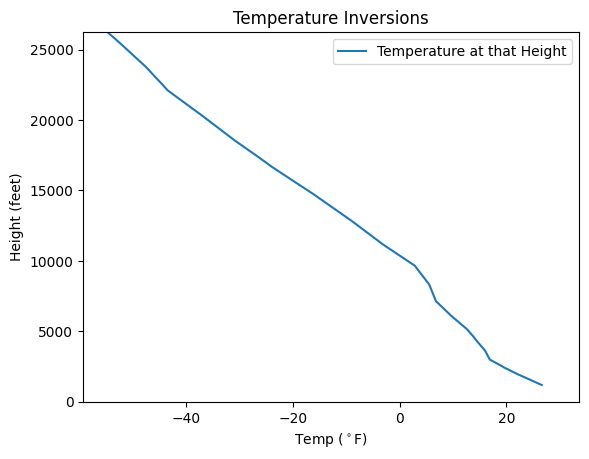

In [6]:
df.plot(x='TEMP_fahrenheit', y='HEIGHT_feet', kind='line')

#axis labels and legend
plt.xlabel(r'Temp ($^\circ$F)')
plt.ylabel('Height (feet)')
plt.title('Temperature Inversions')
plt.legend(['Temperature at that Height'])

#the y axis goes from 0 to the max height looked at
plt.ylim(0,26246.72)

#this sets the x axis using the highest and lowest temperatures in the range
height_range = df[(df['HEIGHT'] >= 0 ) & (df['HEIGHT'] <= 10000)]['HEIGHT']
maxheightindex = box.idxmax()
temps = df.loc[0:maxheightindex, 'TEMP_fahrenheit']
tempmin = temps.min()
tempmax = temps.max()
plt.xlim(tempmin-7,tempmax+7)

#this highlights the regions of the plot that were previously flagged as having an inversion and highlights them
colors = mcolors.LinearSegmentedColormap.from_list('red_to_yellow', ['red', 'yellow'])
for i in range(9):
    flag = flaglist[i]
    boxbottom = boxpartition[i]* 3.28084
    boxtop = boxpartition[i+1]* 3.28084
    color_value = i / 9
    xmid = (tempmin+tempmax)/2
    ymid = (boxbottom+boxtop)/2
    if flag == 1:
        plt.fill_betweenx([boxbottom, boxtop], tempmin-7, tempmax+7, color=colors(color_value), alpha=0.3)
        plt.text(xmid-30, ymid-900, 'Inversion', fontsize=12, color='red', ha='center', va='bottom')
plt.show()

In [7]:
flaglist

[0, 0, 0, 0, 0, 0, 0, 0, 0]

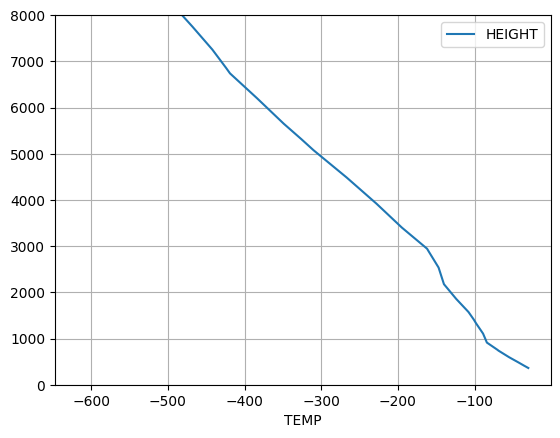

In [8]:
df.plot(x='TEMP', y='HEIGHT', kind='line')
plt.ylim(0,8000)
plt.grid()

In [9]:
df

,TYPE,PRESSURE,HEIGHT,TEMP,DEWPT,WIND DIR,WIND SPD,TEMP_celsius,TEMP_fahrenheit,HEIGHT_feet
0,5,9721,362,-30,-64,343,4,-3.0,26.60,1187.66408
1,5,9667,408,-35,-67,346,4,-3.5,25.70,1338.58272
2,5,9576,484,-43,-69,348,5,-4.3,24.26,1587.92656
3,5,9441,595,-55,-73,350,6,-5.5,22.10,1952.09980
4,5,9267,739,-69,-80,353,7,-6.9,19.58,2424.54076
5,4,9250,753,-70,-81,353,7,-7.0,19.40,2470.47252
6,5,9060,912,-84,-89,350,9,-8.4,16.88,2992.12608
7,5,8835,1107,-89,-98,338,11,-8.9,15.98,3631.88988
8,5,8591,1326,-98,-115,333,13,-9.8,14.36,4350.39384
9,4,8500,1408,-101,-119,333,13,-10.1,13.82,4619.42272
